- 데이터셋 분석대상 기간 : <br>
2017-01-01 ~ 2018-08-31 (1년 8개월) <br>


- 출처 : <br>
https://www.kaggle.com/olistbr/brazilian-ecommerce <br>
https://www.kaggle.com/olistbr/marketing-funnel-olist


- 분석 주제 :<br>
 -> Olist 셀러, 판매월, 제품카테고리 중 평균 review_score가 낮은 건들을 확인하고<br>
 -> 해당 계정들에서 공통적으로 관찰되는 문제점을 파악하여 review_score 개선 전략을 세우자
 
 
- 분석 단계 :<br>
 -> 1단계 : 셀러별 월별 매출액, 판매횟수 및 기타 특징을 입력변수로 사용한 군집화 (등급)<br>
 -> 2단계 : 해당 등급 및 기타 특징을 입력변수로 사용한 review_score 예측<br>
 -> 3단계 : review_score에 영향을 미친 요인을 구체적으로 확인하기 위한 워드클라우드 확인

In [1]:
%autosave 0

Autosave disabled


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", -1)

# 데이터셋 불러오기

In [6]:
%pwd

'C:\\Users\\Chanseo Park\\Desktop\\2차 프로젝트'

In [12]:
data = pd.read_excel('cyn/df_model_origin.xlsx')
data

,review_score,low_review_score_rate,year_month,seller_id,rating,product_category_upper,seller_state,seles_by_OrderNumber,sales,order_nb,delivery_delay_origin,delivery_periods_origin,delivery_preparation_origin,error_rate_based_on_CI,error_rate_based_on_estimated,rate_canceled,canceled_rate_rolling,error_rate_based_on_CI_rolling,error_rate_based_on_estimated_rolling
0,4.200000,20.0,2017-01-01,004c9cd9d87a3c30c522c48c4fc07416,0,home_living,SP,140.574000,702.87,5.0,-19.000000,16.4,0.400000,20.0,20.0,0.0,NaN,NaN,NaN
1,5.000000,0.0,2017-01-01,014c0679dd340a0e338872e7ec85666a,0,home_living,MG,128.200000,128.20,1.0,-64.000000,11.0,1.000000,0.0,0.0,0.0,NaN,NaN,NaN
2,5.000000,0.0,2017-01-01,01cf7e3d21494c41fb86034f2e714fa1,0,home_appliances,PR,227.425000,909.70,4.0,-35.666667,13.0,2.000000,25.0,25.0,0.0,NaN,NaN,NaN
3,4.000000,50.0,2017-01-01,01cf7e3d21494c41fb86034f2e714fa1,0,stationery,PR,91.840000,183.68,2.0,-19.500000,6.5,1.000000,0.0,0.0,0.0,NaN,NaN,NaN
4,4.666667,0.0,2017-01-01,054694fa03fe82cec4b7551487331d74,0,home_appliances,SP,449.546667,1348.64,3.0,-27.666667,14.0,5.333333,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,1.000000,100.0,2018-02-01,5011f0d93373a4c5753adf58ca77af8d,0,food_drink,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.000000,0.000000
21609,1.000000,100.0,2018-02-01,5b581417df4480f632484ba681e53944,4,stationery,SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.222222,0.222222
21610,1.000000,100.0,2018-02-01,c1ed9e3daf6154542826a6996af0fb8c,2,electronics,SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.000000,0.000000
21611,3.000000,100.0,2018-02-01,cca3071e3e9bb7d12640c9fbe2301306,8,home_appliances,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.086957,0.113043


In [13]:
data.isnull().sum()

review_score                             0   
low_review_score_rate                    0   
year_month                               0   
seller_id                                0   
rating                                   0   
product_category_upper                   0   
seller_state                             0   
seles_by_OrderNumber                     6   
sales                                    6   
order_nb                                 6   
delivery_delay_origin                    106 
delivery_periods_origin                  106 
delivery_preparation_origin              6   
error_rate_based_on_CI                   6   
error_rate_based_on_estimated            6   
rate_canceled                            0   
canceled_rate_rolling                    3747
error_rate_based_on_CI_rolling           3748
error_rate_based_on_estimated_rolling    3748
dtype: int64

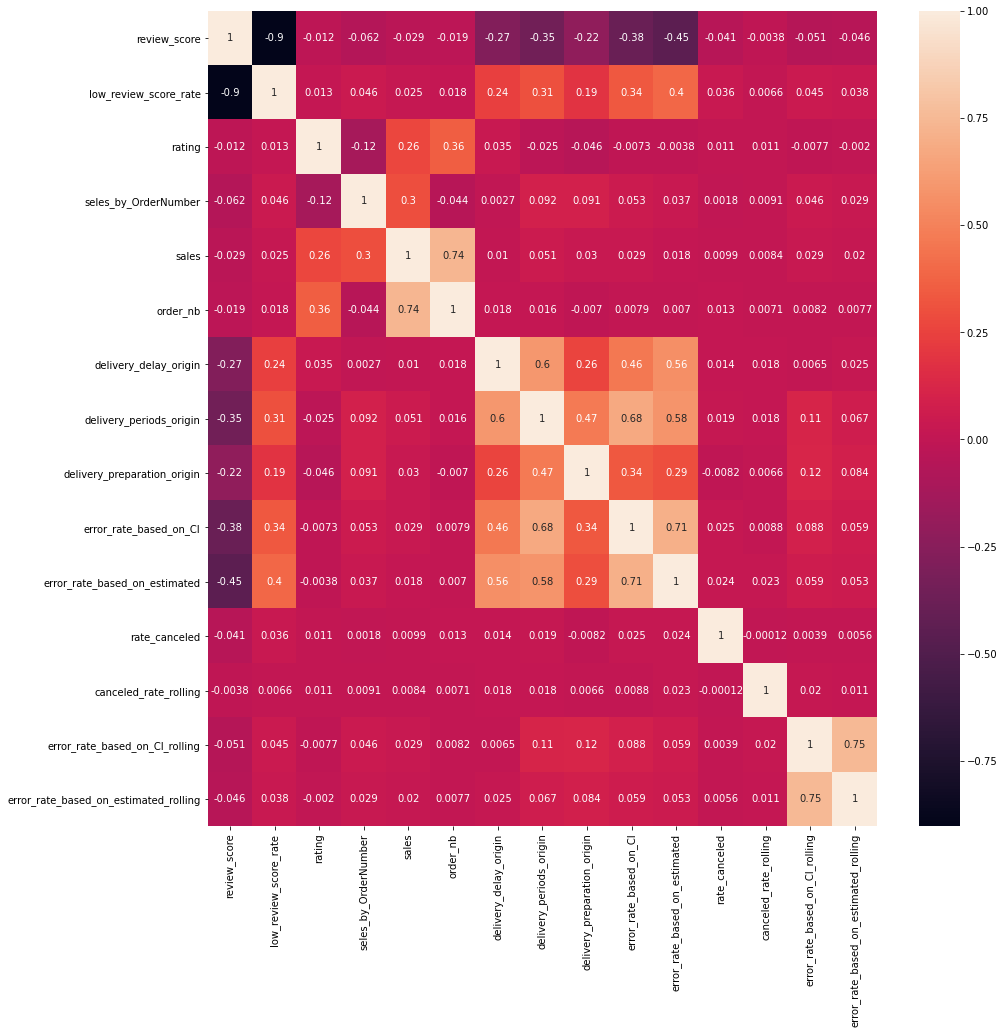

In [14]:
plt.figure(figsize = (15,15))
plt.yticks(rotation = 0)
g = sns.heatmap(data.corr(), annot = True)

# ★1차★
- review_score 평균 예측하는 모델 구축하기

In [15]:
# seller_id 라벨인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['seller_id'] = le.fit_transform(data['seller_id'])

In [16]:
# 미사용 컬럼 제거
data = data.drop(['review_score', 'year_month', 'error_rate_based_on_CI', 'canceled_rate_rolling', 'error_rate_based_on_CI_rolling',
                'error_rate_based_on_estimated_rolling'], axis = 1)
data

,low_review_score_rate,seller_id,rating,product_category_upper,seller_state,seles_by_OrderNumber,sales,order_nb,delivery_delay_origin,delivery_periods_origin,delivery_preparation_origin,error_rate_based_on_estimated,rate_canceled
0,20.0,3,0,home_living,SP,140.574000,702.87,5.0,-19.000000,16.4,0.400000,20.0,0.0
1,0.0,13,0,home_living,MG,128.200000,128.20,1.0,-64.000000,11.0,1.000000,0.0,0.0
2,0.0,18,0,home_appliances,PR,227.425000,909.70,4.0,-35.666667,13.0,2.000000,25.0,0.0
3,50.0,18,0,stationery,PR,91.840000,183.68,2.0,-19.500000,6.5,1.000000,0.0,0.0
4,0.0,53,0,home_appliances,SP,449.546667,1348.64,3.0,-27.666667,14.0,5.333333,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,100.0,896,0,food_drink,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
21609,100.0,1041,4,stationery,SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
21610,100.0,2170,2,electronics,SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0
21611,100.0,2304,8,home_appliances,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0


In [17]:
# 목표변수 분리
label = data['low_review_score_rate']
data = data.drop('low_review_score_rate', axis = 1)

In [18]:
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['seller_id'] = le.fit_transform(data['seller_id'])

In [19]:
# 범주형, 연속형 변수 분리
cat_columns = [c for c, t in zip(data.dtypes.index, data.dtypes) if t == 'O']
num_columns = [c for c in data.columns if c not in cat_columns]
print('Categorical Columns:\n{}\n\n Numeric Columns:\n{}\n'.format(cat_columns, num_columns))

Categorical Columns:
['product_category_upper', 'seller_state']

 Numeric Columns:
['seller_id', 'rating', 'seles_by_OrderNumber', 'sales', 'order_nb', 'delivery_delay_origin', 'delivery_periods_origin', 'delivery_preparation_origin', 'error_rate_based_on_estimated', 'rate_canceled']



In [20]:
# train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3,
                                                       random_state=2021,
                                                       shuffle=True)

x_train.shape, x_test.shape

((15129, 12), (6484, 12))

In [21]:
# 전처리함수
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def preprocess(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [22]:
# 전처리함수 적용
x_train, x_test = preprocess(x_train, x_test)
x_train.shape, x_test.shape

((15129, 52), (6484, 52))

## 모델 결과

In [23]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


models = [['XGBoost', XGBRegressor(random_state=2021,
                                    n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(random_state=2021,
                                      n_jobs=-1)]]

best_loss = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
    if current_loss_rmse < best_loss:
        best_loss  = current_loss_rmse
        best_model = [i, name]
    
    print(f'{name} Model MAE : {current_loss_mae}')
    print(f'{name} Model RMSE: {current_loss_rmse}')

print(f'Best Model: {best_model[-1]}, RMSE: {best_loss}')

XGBoost Model MAE : 21.3206095704839
XGBoost Model RMSE: 29.974627399262516
LightGBM Model MAE : 21.06631871078244
LightGBM Model RMSE: 28.988285112073143
Best Model: LightGBM, RMSE: 28.988285112073143


## 변수 중요도

### feature importance

In [24]:
best_model = models[1][1]
best_model

LGBMRegressor(random_state=2021)

In [25]:
best_model.feature_importances_

array([450, 131, 405, 410,  61, 458, 350, 275,  84,  10,  10,  12,   6,
        29,  28,   7,   7,  13,  11,   7,  15,   9,   7,   3,  18,  10,
         7,   5,  16,  20,   8,   0,   7,   0,   8,   1,   4,   0,  17,
         0,   0,   0,   2,   0,  10,  12,   0,   0,   7,  12,   0,  38])

In [26]:
pd.DataFrame(sorted(zip(best_model.feature_importances_, x_train.columns), reverse=True), columns=['Value','Feature'])

,Value,Feature
0,458,delivery_delay_origin
1,450,seller_id
2,410,sales
3,405,seles_by_OrderNumber
4,350,delivery_periods_origin
5,275,delivery_preparation_origin
6,131,rating
7,84,error_rate_based_on_estimated
8,61,order_nb
9,38,SP


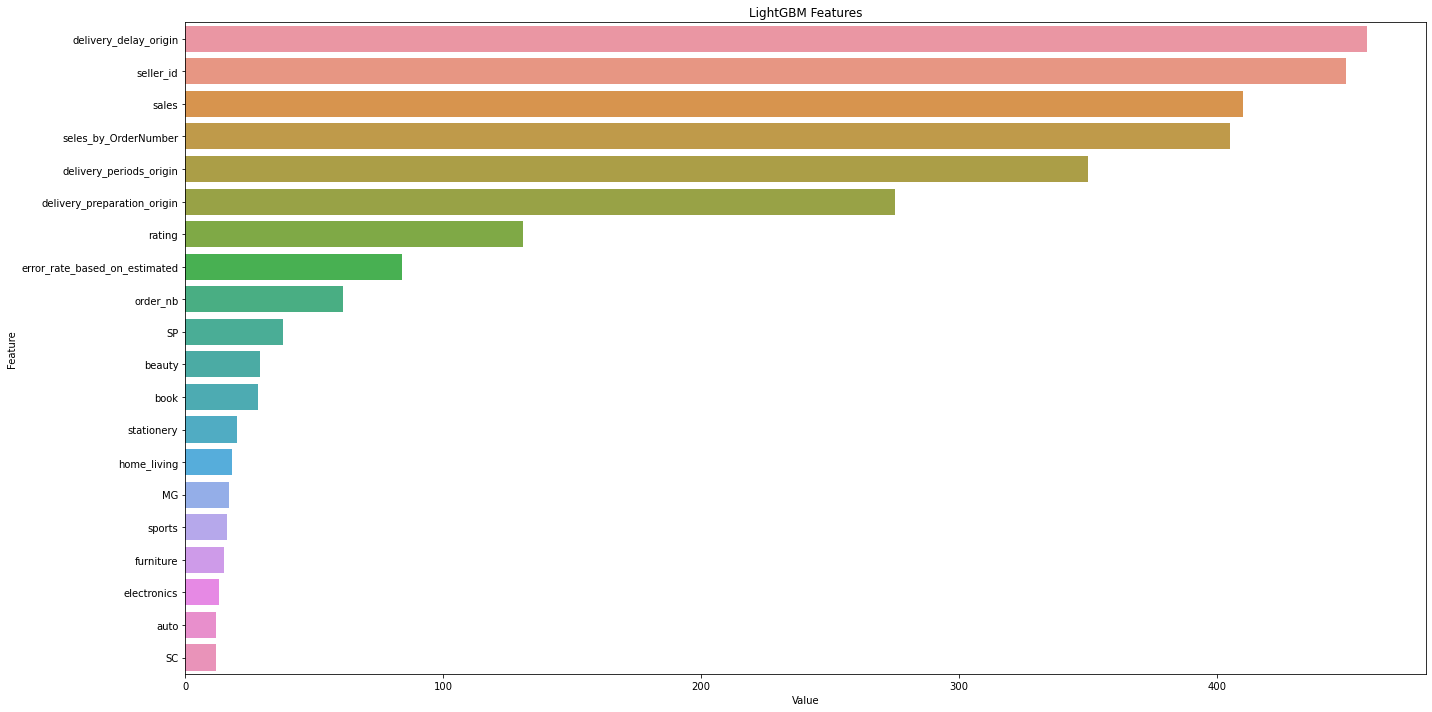

In [27]:
# Feature importance
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

### permutation importance

In [28]:
from sklearn.inspection import permutation_importance

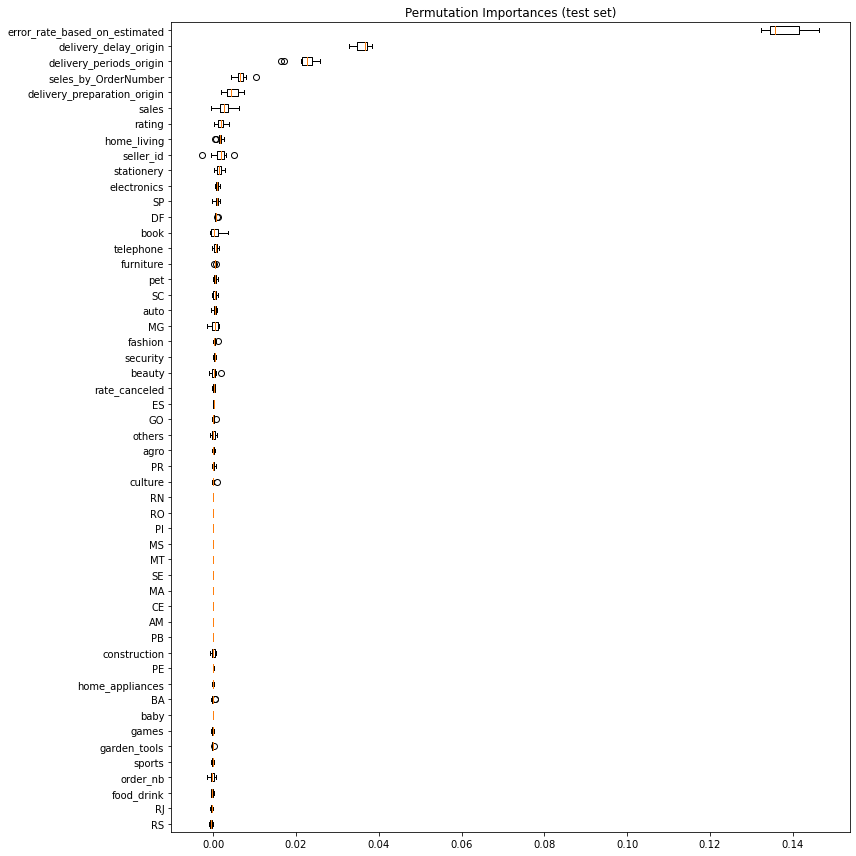

In [29]:
result = permutation_importance(best_model, x_test, y_test, n_repeats=10,
                                 n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (12,12))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

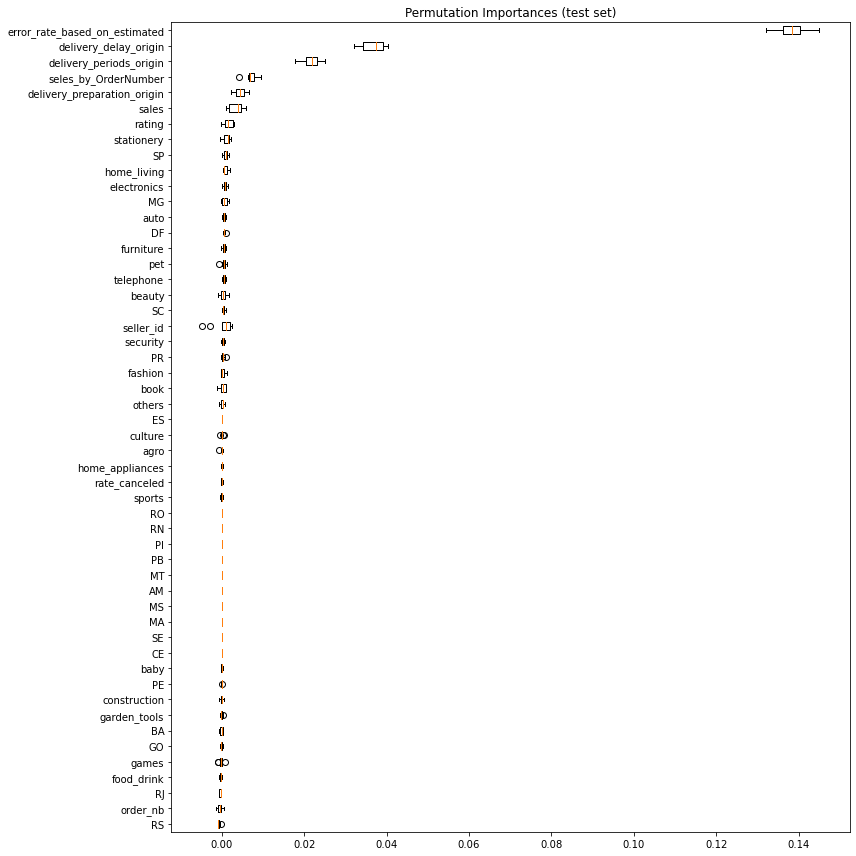

In [30]:
# 비교용
result = permutation_importance(best_model, x_test, y_test, n_repeats=10,
                                 n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (12,12))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Cross Validation
- CV 전보다 RMSE가 높아짐

In [34]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

val_scores = list()

kf = KFold(n_splits=5, shuffle=True, random_state=2021)

for i, (trn_idx, val_idx) in enumerate(kf.split(data, label)):
    x_train, y_train = data.iloc[trn_idx], label[trn_idx]
    x_test, y_test = data.iloc[val_idx], label[val_idx]
    
    # 전처리
    x_train, x_test = preprocess(x_train, x_test)
    
    # 모델 정의
    lgbm = LGBMRegressor(random_state=2021, n_jobs=-1)
    
    # 모델 학습
    lgbm.fit(x_train, y_train)
    y_pred = lgbm.predict(x_test)
    
    # 훈련, 검증 데이터 RMSE 확인
    trn_rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = lgbm.predict(x_train)))
    val_rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))
    print('{} Fold, train rmse_score : {:.4f}, validation rmse_score : {:.4f}'.format(i, trn_rmse, val_rmse))
    
    val_scores.append(val_rmse)

# 교차 검증 rmse_score 평균 계산하기
print('Cross Validation Score : {:.4f}'.format(np.mean(val_scores)))

0 Fold, train rmse_score : 26.5379, validation rmse_score : 29.1246
1 Fold, train rmse_score : 26.4577, validation rmse_score : 29.4561
2 Fold, train rmse_score : 26.5759, validation rmse_score : 28.9192
3 Fold, train rmse_score : 26.4951, validation rmse_score : 29.1994
4 Fold, train rmse_score : 26.2093, validation rmse_score : 30.4955
Cross Validation Score : 29.4389


## Hyperparameter Tuning

- cv만 했을때보다는 나아졌으나 base 모델보다는 RMSE가 높아짐

### GridSearch

In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
params = {'n_estimators':[20, 40, 60],
          'max_depth':[3, 4],
         'learning_rate' : [0.01, 0.05, 0.1]}

lgbm_tuning = GridSearchCV(LGBMRegressor(random_state=2021), 
                   params, n_jobs= 5, scoring='neg_root_mean_squared_error')

In [47]:
lgbm_tuning.fit(x_train, y_train)

GridSearchCV(estimator=LGBMRegressor(random_state=2021), n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4], 'n_estimators': [20, 40, 60]},
             scoring='neg_root_mean_squared_error')

In [42]:
# 1차
# params = {'n_estimators':[50, 100, 200],
#           'max_depth':[3, 4],
#          'learning_rate' : [0.01, 0.05, 0.1]}

# print('GridSearchCV best rmse score : {:.4f}, best_params : {}'.format(-lgbm_tuning.best_score_, lgbm_tuning.best_params_))

GridSearchCV best rmse score : 29.0307, best_params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [45]:
# 2차
# params = {'n_estimators':[40, 50, 60],
#           'max_depth':[3, 4],
#          'learning_rate' : [0.01, 0.05, 0.1]}

print('GridSearchCV best rmse score : {:.4f}, best_params : {}'.format(-lgbm_tuning.best_score_, lgbm_tuning.best_params_))

GridSearchCV best rmse score : 29.0289, best_params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40}


In [52]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

val_scores = list()

kf = KFold(n_splits=5, shuffle=True, random_state=2021)

for i, (trn_idx, val_idx) in enumerate(kf.split(data, label)):
    x_train, y_train = data.iloc[trn_idx], label[trn_idx]
    x_test, y_test = data.iloc[val_idx], label[val_idx]
    
    # 전처리
    x_train, x_test = preprocess(x_train, x_test)
    
    # 모델 정의
    lgbm = LGBMRegressor(random_state=2021, n_jobs=-1,
                        learning_rate = 0.1, max_depth = 3, n_estimators = 40)
    
    # 모델 학습
    lgbm.fit(x_train, y_train)
    y_pred = lgbm.predict(x_test)
    
    # 훈련, 검증 데이터 RMSE 확인
    trn_rmse = np.sqrt(mean_squared_error(y_true = y_train, y_pred = lgbm.predict(x_train)))
    val_rmse = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred))
    print('{} Fold, train rmse_score : {:.4f}, validation rmse_score : {:.4f}'.format(i, trn_rmse, val_rmse))
    
    val_scores.append(val_rmse)

# 교차 검증 rmse_score 평균 계산하기
print('Cross Validation Score : {:.4f}'.format(np.mean(val_scores)))

0 Fold, train rmse_score : 29.0438, validation rmse_score : 28.9079
1 Fold, train rmse_score : 28.9523, validation rmse_score : 29.1574
2 Fold, train rmse_score : 29.0770, validation rmse_score : 28.7441
3 Fold, train rmse_score : 28.9970, validation rmse_score : 29.0618
4 Fold, train rmse_score : 28.6946, validation rmse_score : 30.2101
Cross Validation Score : 29.2163


### RandomizedSearch

In [58]:
params = {'n_estimators':(10, 10000),
          'max_depth': (1, 10),
          'learning_rate' : (0.05, 0.5),
           'num_leaves': (10, 10000)
}

lgbm_tuning_rs = RandomizedSearchCV(estimator=LGBMRegressor(random_state = 2021), 
                                    n_jobs= -1, scoring='neg_root_mean_squared_error',
                                    param_distributions = params, cv = 5, verbose = 1)

In [59]:
lgbm_tuning_rs.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  1.1min remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=2021), n_jobs=-1,
                   param_distributions={'learning_rate': (0.05, 0.5),
                                        'max_depth': (1, 10),
                                        'n_estimators': (10, 10000),
                                        'num_leaves': (10, 10000)},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [57]:
# 1차
# print('RanbdomSearchCV best rmse : {:.4f}, best_params : {}'.format(-lgbm_tuning_rs.best_score_, lgbm_tuning_rs.best_params_))

RanbdomSearchCV best rmse : 29.0462, best_params : {'num_leaves': 1000, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.1}


In [60]:
# 2차
print('RanbdomSearchCV best rmse : {:.4f}, best_params : {}'.format(-lgbm_tuning_rs.best_score_, lgbm_tuning_rs.best_params_))

RanbdomSearchCV best rmse : 29.1395, best_params : {'num_leaves': 10, 'n_estimators': 10000, 'max_depth': 1, 'learning_rate': 0.05}


# 결론

- LightGBM Regressor 성능이 가장 높았으며 CV, hyperparameter tuning을 통해 기본모델 성능 개선 x
- 
-

**to-do**
- RandomizedSearchCV 정확히 어떻게 쓰는건지
- feature selection